In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mesh_utils import rectangular_mesh # import everything from custom module mesh_utils

%matplotlib notebook

Let's first create an instance of the class `rectangular_mesh`; this means, we are going to create a variable named `m` of type `rectangular_mesh` itself contains variables and functions itself.

In [2]:
m = rectangular_mesh(11, 1000, 11, 100) # arguments: nx, lx, ny, ly

Notice that, when initialising a class (as we just did by calling `rectangular_mesh(11, 1000, 11, 100)`), we are implicitly calling the _constructor_ of the class. The constructor is a special function defined inside the class, that always has the name `__init(...)__` (notice the double underscore). Notice that the first argument of any function defined inside a class is always mandatorily `self`; however, `self` needs to appear only in the definition of the function, and not when the function is called. Here indeed we are calling `rectangular_mesh(11, 1000, 11, 100)` and not `rectangular_mesh(self, 11, 1000, 11, 100)`.

After initialising the class, we can access variables and functions inside `m` using a dot, for instance:

In [3]:
print(m.nx)
print(m.ny)

11
11


Here `nx` and `ny` were actually passed to the constructor; the constructor then took care of storing them inside the class. However, the constructor also does something else: it calculates the grid resolutions `dx` and `dy`, and stores them as variables:

In [4]:
print(m.dx)
print(m.dy)

100.0
10.0


Moreover, the constructor also calculates vectors `x` and `y` containing grid point positions in the two directions; they can be accessed as:
```
m.x
m.y
```

As already said, `m` also contains functions. For instance, function `get_mem_pos(ix, iy)` returns index in memory of a point of given x, y indices $i_x, i_y$:

In [5]:
imem = m.get_mem_pos(2,3)
print(imem)

25


Also hte inverse of such function is defined:

In [6]:
ixx, iyy = m.get_mat_pos(imem)
print(ixx, iyy)

2 3


## Creating unknown; plotting

First off, we will create the vector of unknowns; this has simply dimensions $N_x\cdot N_y$:

In [7]:
unknowns = np.zeros(m.nx*m.ny)

The vector of unknowns is initialised as all zeros. Starting from point 2,1 (third position on x-axis, second position on y-axis), we will now write known values into all its neighbouring points.

In [8]:
p = m.get_mem_pos(2,1) # get index of desired point
unknowns[p] = 1 # set value at desired point

n,s,w,e = m.get_compass(p) # get indices of neighbouring points

# assign values to neighbouring points
unknowns[n] = 2
unknowns[s] = 3
unknowns[w] = 4
unknowns[e] = 5

Now that we are done writing values, we can prepare the vector of unknowns for plotting. We have to do two operations:
1. reshaping the vector to a matrix; this is a very fast operation, since no data is being actually moved in memory. Remember that also multi-dimensional arrays are stored in memory as 1D, since memory is 1D!
2. transposing the matrix so obtained; this because the plotting function requires that each value of the last index corresponds to a different value of x.

In [9]:
# treatment for mesh before plotting
unknowns = unknowns.reshape((m.nx, m.ny))
unknowns = unknowns.transpose()

Now, the last step before plotting is creating the mesh. Actually, we could have a quick rendering of our data to check if everything is correct before moving on to advanced plotting:

<IPython.core.display.Javascript object>


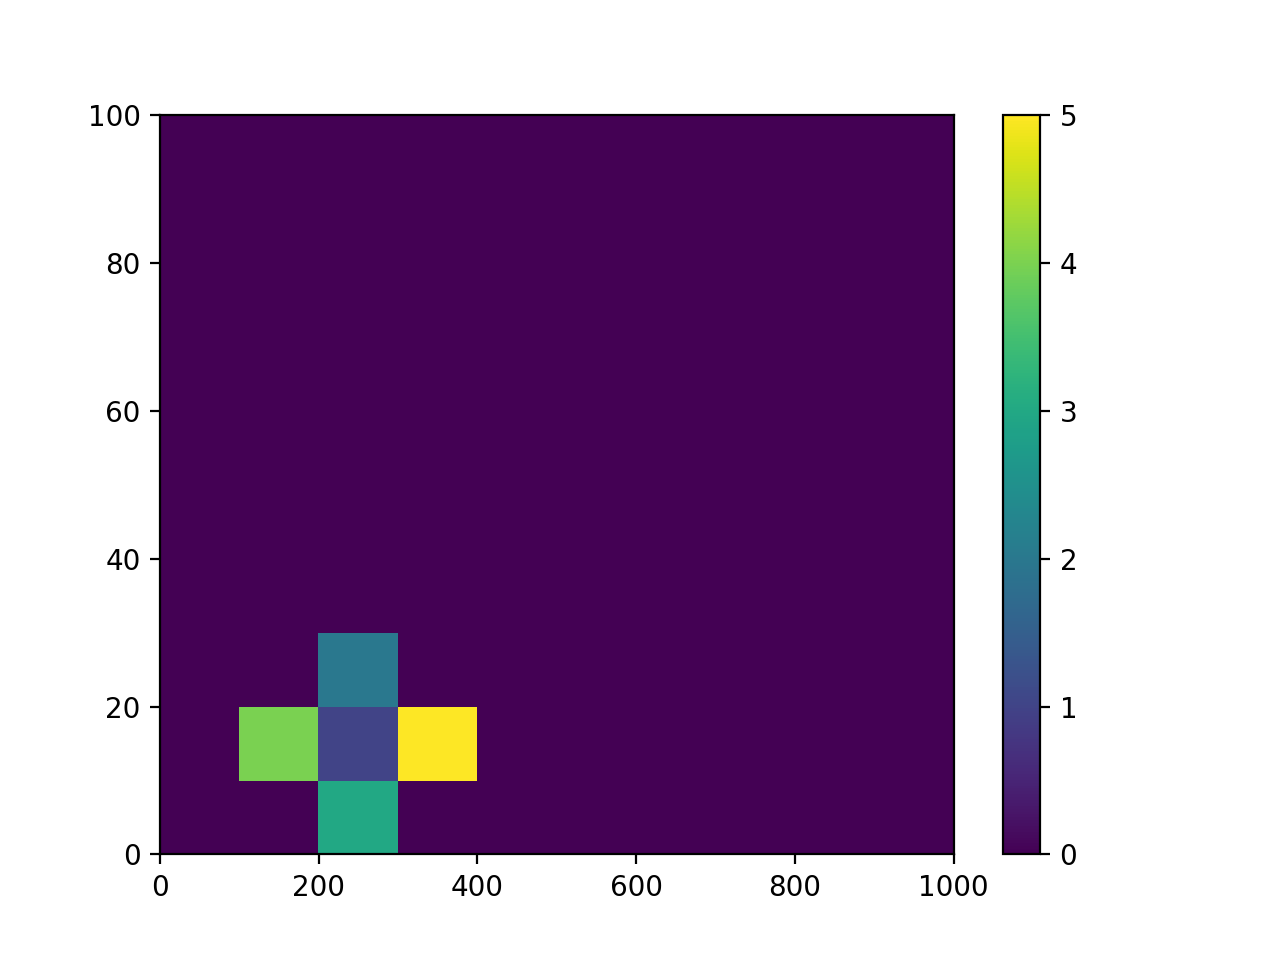

In [10]:
fig, ax = plt.subplots()
pos = ax.pcolormesh(m.x,m.y,unknowns)
fig.colorbar(pos)

Which confirms that our mesh is working as intended. There's a catch however: the way we used function `pcolormesh` does not really suit our application. To understand this, let's have a look at the following extract from [pcolormesh documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html). Pcolormesh takes the following input:
``` python
pcolormesh([X, Y,] C)

```
where `X` and `Y` are optional arguments; here, we omitted them indeed. The only argument we passed is `C` (which is actually `unknowns` in our case. So, what pcolormesh does _by default_ is coloring an entire cell depending on the value of `C[i,j]`; the cell is delimited by values specified in X and Y, so that:
```
(X[i+1, j], Y[i+1, j])        (X[i+1, j+1], Y[i+1, j+1])
                     +--------+
                     | C[i,j] |
                     +--------+
    (X[i, j], Y[i, j])        (X[i, j+1], Y[i, j+1])
```
In other words, pcolormesh assumes that the value _inside_ the cell is known, but this is not our case: in fact, we know the value of what we are plotting _at the corners_ of the cell - which is, at the nodes. What we want to do is interpolating the values inside the cell!

To do so, we have to pass an optional argument to pcolormesh, so that it behaves as desired. This is doing by passing `shading='gouraud'`; in this way, color inside the cell is interpolated from nodal values:
```
(X[i+1, j], Y[i+1, j], C[i+1,j])        (X[i+1, j+1], Y[i+1, j+1], C[i+1,j+1])
                              +----------+
                              |  interp. |
                              +----------+
      (X[i, j], Y[i, j], C[i,j])        (X[i, j+1], Y[i, j+1], C[i,j+1])
```

<IPython.core.display.Javascript object>


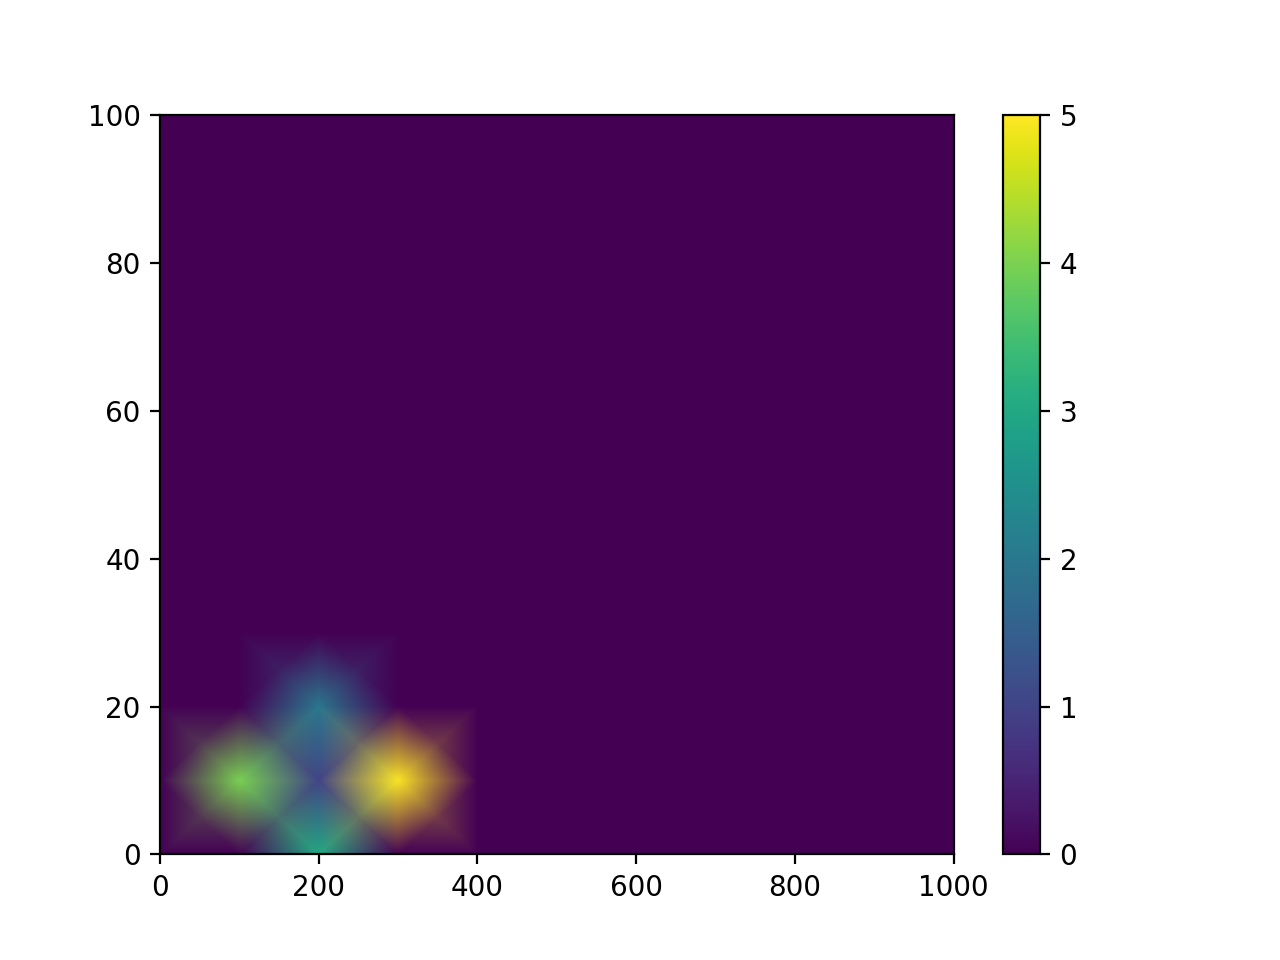

In [11]:
fig, ax = plt.subplots()
pos = ax.pcolormesh(m.x, m.y, unknowns, shading='gouraud')
fig.colorbar(pos)

It doesn't look great aesthetically in this case (because what we are plotting is "artificial"), but it is exactly what we need.